In [1]:
import itertools
import pathlib
import pyam

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# these functions can be found in utils.py in this same directory
from utils import (
    make_quantiles,
    make_sequestration_plot_data,
    sequestration_plot,
    share_of_cdr_data,
)

sns.set_style('whitegrid')

<IPython.core.display.Javascript object>

# Load Data

In [14]:
data_path = pathlib.Path('../data')

paper_data = pd.concat([
    pd.read_csv(data_path / 'gidden_et_al_2022_ar6_reanalysis_data.csv'),
    pd.read_csv(data_path / 'additional_analysis_data.csv'),
])

df = pyam.IamDataFrame(paper_data)
df.load_meta(data_path / 'gidden_et_al_2022_ar6_reanalysis_meta.csv')

pyam.core - INFO: Reading meta indicators for 914 out of 1871 scenarios


In [15]:
df.meta.loc['GCAM 5.2', 'NGFS1_Current policies (Hot house world, Rep)']

Category                                                                                     NaN
Category_name                                                                                NaN
Category_subset                                                                              NaN
Subset_Ch4                                                                                   NaN
Category_Vetting_historical                                                                  NaN
                                                                                            ... 
Interpolated Net-Zero Year for AR6 Reanalysis|OSCARv3.2|Emissions|Kyoto Gases|Direct Only    NaN
Interpolated Net-Zero Year for AR6 Reanalysis|OSCARv3.2|Emissions|Kyoto Gases                NaN
Interpolated Net-Zero Year for Emissions|CO2                                                 NaN
Interpolated Net-Zero Year for AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Direct Only            NaN
Interpolated Net-Zero Year for

In [3]:
# Confirm there are no C1-C3 in current policies
meta = df.meta.copy()
meta.query("Policy_category_name == 'P1b: Current policies'").Category.unique()

array(['C7', 'C6', 'C5'], dtype=object)

In [4]:
categories_to_temp = {'C1': '1.5C', 'C3': '2C', 'Current Policies': 'Current Policies'}
df.meta['Temperature'] = df.meta['Category'].replace(categories_to_temp)
df.set_meta(
    'Current Policies', name='Temperature',
    index=df.meta.query("Policy_category_name == 'P1b: Current policies'").index
)

In [11]:
df.meta.query("Policy_category_name == 'P1b: Current policies'").index.to_series().to_csv('C:/Users/gidden/Downloads/current_policies.csv', index=True)

In [5]:
variable_rename = {
    'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land': 'Total',
    'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land|Direct': 'Direct',
    'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land|Indirect': 'Indirect',
}
df.rename(variable=variable_rename, inplace=True)
variables = list(variable_rename.values())
data = df.filter(region='World', variable=variables, year=[2020, 2030, 2050])

In [25]:
data = data.offset(year=2020).filter(year=2020, keep=False)

In [26]:
def make_removal_plot_data(df, variables, temps, years=[2030, 2050]):
    # pyam version of quantile data
    data = pyam.concat([
        (
            df
            .filter(region='World', variable=variable)
            .filter(Temperature=temp)
            .compute.quantiles((0.25, 0.5, 0.75))
            .rename(model={'Quantiles': temp})
        ) for temp, variable in itertools.product(temps, variables)
    ])
    
    # data ready for plotting
    pdata = (
        data
        .filter(year=years)
        .as_pandas(meta_cols=False)
        .drop(columns=['region', 'unit'])
        .set_index(['year', 'model', 'scenario', 'variable'])
        ['value']
        .unstack(['scenario', 'variable'])
        / 1e3
    )
    pdata = pdata.reindex(index=pdata.index[::-1]) # reverse ordering so plots are in correct order
    return data, pdata

_data, pdata = make_removal_plot_data(data, variables, list(categories_to_temp.values()), years=[2030, 2050])

In [27]:
pdata

scenario                   0.25                           0.5            \
variable                 Direct  Indirect     Total    Direct  Indirect   
year model                                                                
2050 Current Policies -0.438711  1.794372  1.490679 -0.338451  2.208418   
     2C                0.191154 -0.805870 -0.651755  1.325935 -0.511882   
     1.5C              1.083450 -2.182859 -0.557077  2.902627 -1.921897   
2030 Current Policies  0.000150  0.948341  1.009756  0.053021  1.065740   
     2C                0.079269  0.323443  0.849952  0.698637  0.691594   
     1.5C              0.889132 -0.338238  0.942907  1.569740  0.178360   

scenario                             0.75                      
variable                  Total    Direct  Indirect     Total  
year model                                                     
2050 Current Policies  2.025546 -0.040622  2.497194  2.419194  
     2C                1.021435  2.996143 -0.164083  2.546991  
     1.5C              1.167449  3.942813 -1.472434  2.017276  
2030 Current Policies  1.141913  0.189638  1.151833  1.249932  
     2C                1.134412  1.986356  0.903315  2.830674  
     1.5C              1.755680  2.570618  0.404256  2.954663

In [28]:
line_colors = {
    'Current Policies': '#F9C8B7',
    '1.5C': '#97CEE4',
    '2C': '#6F7899', 
}


def removal_plot(pdata, order=None, hlines=True, stacked=True, cmap='PiYG', ax=None, legend=pyam.plotting.OUTSIDE_LEGEND['bottom']):
    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 5))
    
    base, mins, maxs = pdata['0.5'], pdata['0.25'], pdata['0.75']
    if order:
        base = base.loc[order]
    errors = [[base[c] - mins[c], maxs[c] - base[c]] for c in base.columns]
    
    if hlines:
        for (idx, hline) in base['Total'].items():
            ax.axhline(hline, c=line_colors[idx], label=idx)    
    base.plot.bar(yerr=errors, capsize=4, rot=0, stacked=stacked, ax=ax, cmap=cmap, alpha=0.7, legend=False)

    if legend:
        ax.legend(**legend)
    return ax

In [29]:
order = ['1.5C', '2C', 'Current Policies']

(-2.5, 4.5)

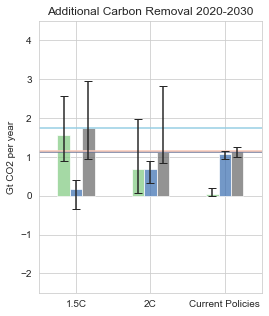

In [34]:
year = 2030

size = 4
fig, ax = plt.subplots(figsize=(1 * size, 1.25 * size))
legend = False
removal_plot(pdata.loc[year], stacked=False, hlines=True, cmap='Accent', ax=ax, order=order, legend=legend)
ax.set_title(f'Additional Carbon Removal 2020-{year}')
ax.set_ylabel('Gt CO2 per year') 
ax.set_xlabel('')
ax.set_ylim(-2.5, 4.5)

(-2.5, 4.5)

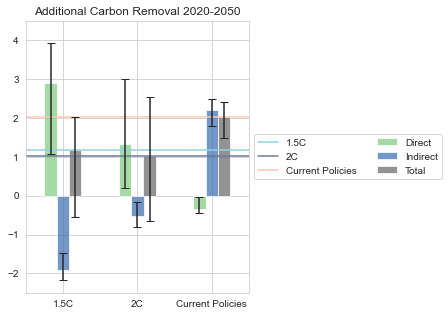

In [35]:
year = 2050

size = 4
fig, ax = plt.subplots(figsize=(1 * size, 1.25 * size))
legend = pyam.plotting.OUTSIDE_LEGEND['right'].copy()
legend.update(ncol= 2)
removal_plot(pdata.loc[year], stacked=False, hlines=True, cmap='Accent', ax=ax, order=order, legend=legend)
ax.set_title(f'Additional Carbon Removal 2020-{year}')
ax.set_xlabel('')
ax.set_ylim(-2.5, 4.5)